In [1]:
import cv2
import numpy as np
from pickle import load
from PIL import Image as PILImage
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from ATCVP.ATCVP import Model
%matplotlib inline

In [2]:
n_past = 5
n_future = 10
model_dir = "/home/kiyanoush/Cpp_ws/src/haptic_finger_control/src/ATCVP/blacked/"
model_name_save_appendix = "ATCVP_model"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

features = dict([("device", device), ("n_past", n_past), ("n_future", n_future), ("model_dir", model_dir),\
                                ("model_name_save_appendix", model_name_save_appendix), ("criterion", nn.MSELoss())])
pred_model = Model(features)
pred_model.load_state_dict(torch.load("/home/kiyanoush/Cpp_ws/src/haptic_finger_control/src/ATCVP/blacked/ATCVP_model", map_location='cpu'))

<All keys matched successfully>

In [3]:
data_path_new = "/home/kiyanoush/Cpp_ws/src/haptic_finger_control/RT-Data/proactive/007"
touch = np.load(data_path_new + "/haptic_finger_raw.npy")
robot = np.load(data_path_new + "/robot_pose.npy")[:, :6]
haptic_finger_scaled = np.load(data_path_new + "/haptic_finger_scaled.npy")
final_touch = np.load(data_path_new + "/haptic_finger_final.npy")
action_final = np.load(data_path_new + "/aciton_final.npy")

In [4]:
scaled_action = np.zeros_like(robot)

scaler_path = '/home/kiyanoush/Cpp_ws/src/haptic_finger_control/scalars'
robot_min_max_scalar = [load(open(scaler_path + '/robot_min_max_scalar_'+feature +'.pkl', 'rb'))\
                        for feature in ['px', 'py', 'pz', 'ex', 'ey', 'ez']]
for index, min_max_scalar in enumerate(robot_min_max_scalar):
    scaled_action[:, index] = np.squeeze(min_max_scalar.transform(robot[:, index].reshape(-1, 1)))

In [5]:
finger_sensor = np.ascontiguousarray(touch.astype(np.uint8))
raw = []
for k in range(len(finger_sensor)):
    tmp = cv2.rectangle(finger_sensor[k],(0,230),(480,480),(0,0,0),-1)
    tmp = PILImage.fromarray(tmp).resize((64, 64), PILImage.Resampling.LANCZOS)
    tmp = np.fromstring(tmp.tobytes(), dtype=np.uint8)
    tmp = tmp.reshape((64, 64, 3))
    tmp = tmp.astype(np.float32) / 255.0
    raw.append(tmp)
finger_sensor = np.array(raw)

/tmp/ipykernel_64592/1792379136.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  tmp = np.fromstring(tmp.tobytes(), dtype=np.uint8)


In [6]:
print(finger_sensor.shape)

(117, 64, 64, 3)


In [7]:
touch_horizon_1 = []
touch_seq = []
action_seq = []
action_1 = []
for i in range(len(finger_sensor)-17):
       touch_horizon_1.append(finger_sensor[i:i+15])
       action_1.append(scaled_action[i:i+15])

touch_seq = np.array(touch_horizon_1).astype(np.float32)
action_seq = np.array(action_1).astype(np.float32)

touch_seq = torch.from_numpy(touch_seq)
action_seq = torch.from_numpy(action_seq)

touch = touch_seq.unsqueeze(0).permute([1, 0, 2, 3, 4, 5])[72].permute([ 1, 0, 4, 3, 2])
action = action_seq.unsqueeze(0).permute([1, 0, 2, 3])[72].permute([ 1, 0, 2])

action = action[:, 0, :].view(15, 1, 6)
touch = touch[:5, 0, :, :, :].view(5, 1, 3, 64 ,64)

In [8]:
print(touch.shape)

torch.Size([5, 1, 3, 64, 64])


In [9]:
predictions = pred_model.forward(action, touch)

In [10]:
predictions = torch.permute(predictions, (1, 0, 4, 3, 2)).detach().numpy()

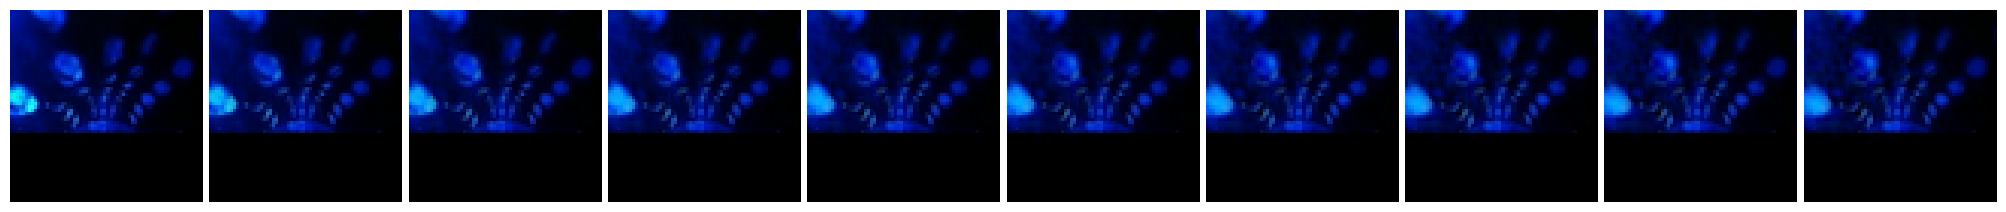

In [11]:
rownum = 0
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for col in range(10):
    axs[col].imshow(np.clip(predictions[rownum, col], 0, 1), cmap="YlOrBr")
    axs[col].axis('off')
    axs[col].set_xticklabels([])
    axs[col].set_yticklabels([])
fig.tight_layout(pad=0.5)
plt.show()

In [12]:
final_touch = torch.from_numpy(final_touch).float()
action_final = torch.from_numpy(action_final).float()

In [13]:
print(final_touch.shape)

torch.Size([117, 5, 3, 64, 64])


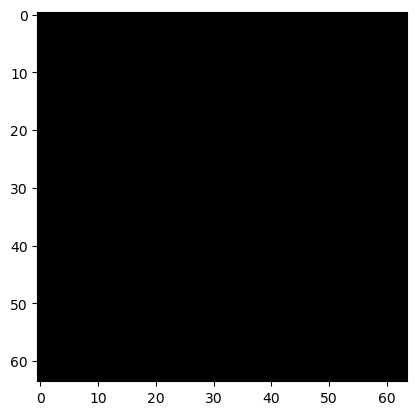

In [14]:
plt.imshow((final_touch[77, 4].permute([1, 2, 0]) - touch[0, 0].permute([2, 1, 0])))

In [15]:
sample_action = action_final[80].view(15, 1, 6)
sampe_touch = final_touch[80].view(5, 1, 3 ,64, 64)

In [16]:
predictionsss = pred_model.forward(sample_action, sampe_touch)

In [17]:
predictionsss = torch.permute(predictionsss, (1, 0, 3, 4, 2)).detach().numpy()

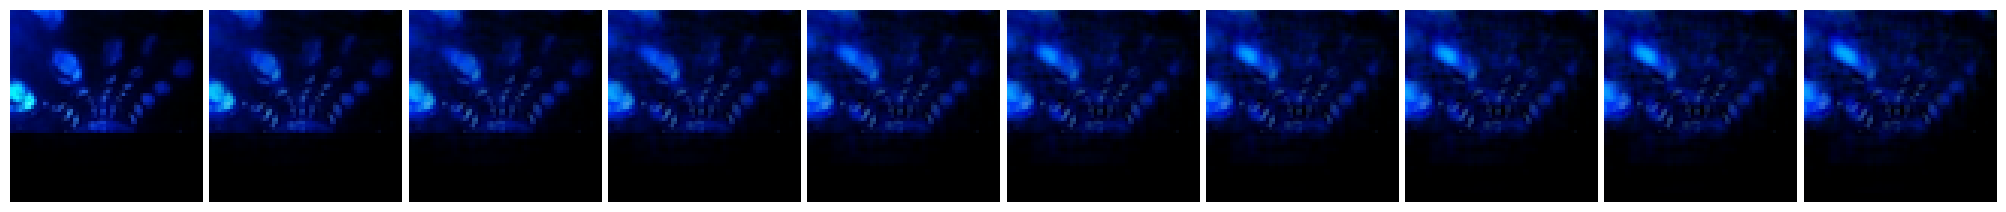

In [18]:
rownum = 0
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for col in range(10):
    axs[col].imshow(np.clip(predictionsss[rownum, col], 0, 1), cmap="YlOrBr")
    axs[col].axis('off')
    axs[col].set_xticklabels([])
    axs[col].set_yticklabels([])
fig.tight_layout(pad=0.5)
plt.show()

In [19]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [18]:
def drop_missed_frames(stem):
    stem_pose = np.copy(stem)
    zero_indeces = np.where(stem==0)[0]
    non_zero_indeces = np.where(stem!=0)[0]
    for i in zero_indeces:
        substitude_index = find_nearest(non_zero_indeces, i)
        stem_pose[i] = stem_pose[substitude_index]
    
    return stem_pose

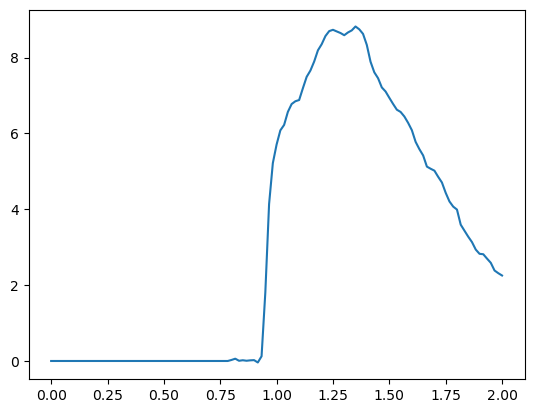

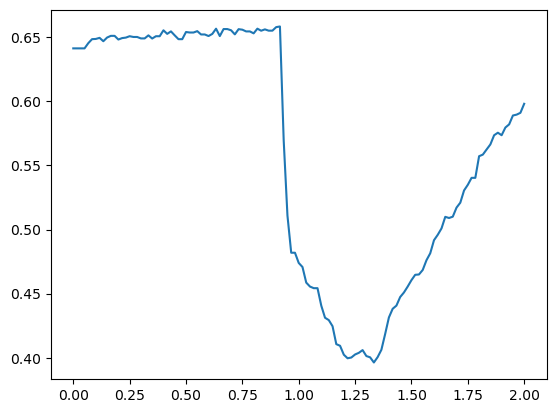

In [33]:
action_reactive = np.load("/home/kiyanoush/Cpp_ws/src/haptic_finger_control/RT-Data/reactive/043/robot_velocity.npy")
stem_reactive = np.load("/home/kiyanoush/Cpp_ws/src/haptic_finger_control/RT-Data/reactive/043/localisation.npy")
stem_reactive = drop_missed_frames(stem_reactive)
plt.plot(np.arange(len(action_reactive))/60, action_reactive[:, -1]*57)
plt.figure()
plt.plot(np.arange(len(action_reactive))/60, stem_reactive)

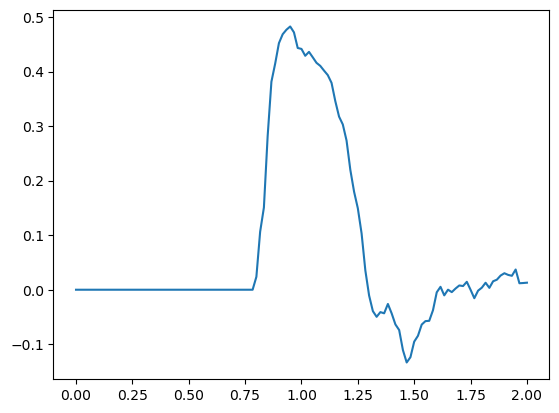

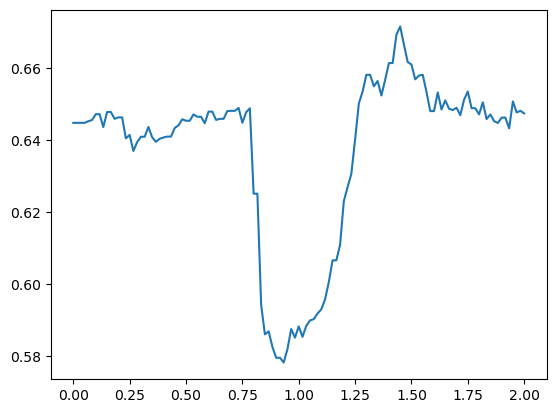

In [35]:
action_reactive = np.load("/home/kiyanoush/Cpp_ws/src/haptic_finger_control/RT-Data/reactive/043/robot_velocity.npy")
stem_reactive = np.load("/home/kiyanoush/Cpp_ws/src/haptic_finger_control/RT-Data/reactive/043/localisation.npy")
stem_reactive = drop_missed_frames(stem_reactive)
plt.plot(np.arange(len(action_reactive))/60, action_reactive[:, -1]*57)
plt.figure()
plt.plot(np.arange(len(action_reactive))/60, stem_reactive)

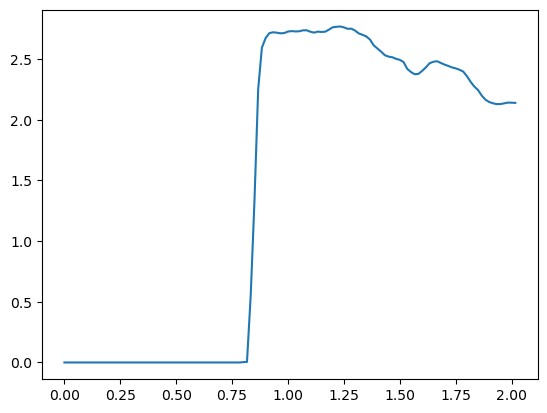

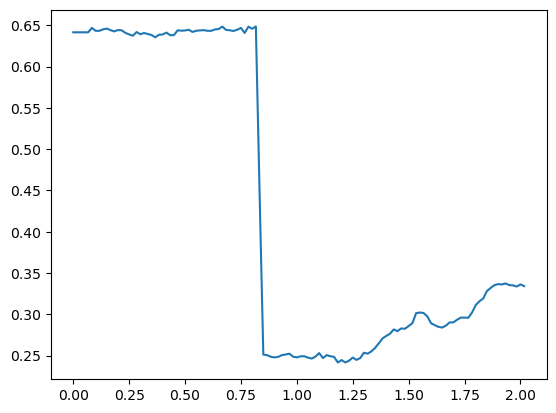

In [36]:
action_reactive = np.load("/home/kiyanoush/Cpp_ws/src/haptic_finger_control/RT-Data/reactive/043/robot_velocity.npy")
stem_reactive = np.load("/home/kiyanoush/Cpp_ws/src/haptic_finger_control/RT-Data/reactive/043/localisation.npy")
stem_reactive = drop_missed_frames(stem_reactive)
plt.plot(np.arange(len(action_reactive))/60, action_reactive[:, -1]*57)
plt.figure()
plt.plot(np.arange(len(action_reactive))/60, stem_reactive)

(121, 1)


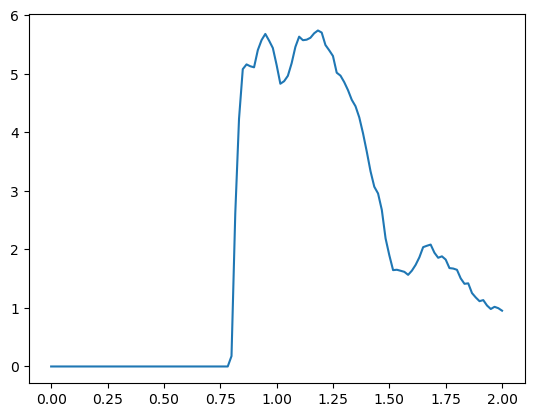

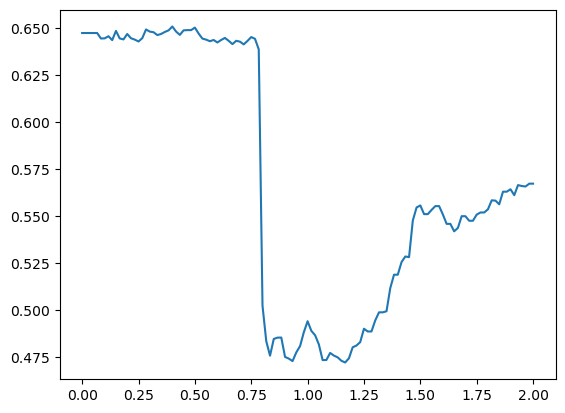

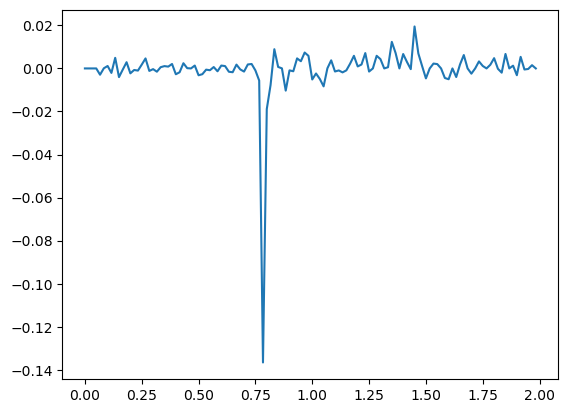

In [67]:
action_reactive = np.load("/home/kiyanoush/Cpp_ws/src/haptic_finger_control/RT-Data/reactive/final_tests/015/robot_velocity.npy")
stem_reactive = np.load("/home/kiyanoush/Cpp_ws/src/haptic_finger_control/RT-Data/reactive/final_tests/015/localisation.npy")
stem_reactive = drop_missed_frames(stem_reactive)
plt.plot(np.arange(len(action_reactive))/60, action_reactive[:, -1]*57)
plt.figure()
plt.plot(np.arange(len(action_reactive))/60, stem_reactive)
print(stem_reactive.shape)
plt.figure()
plt.plot(np.arange(len(action_reactive)-1)/60, np.diff(stem_reactive[:, 0]))

(121, 1)


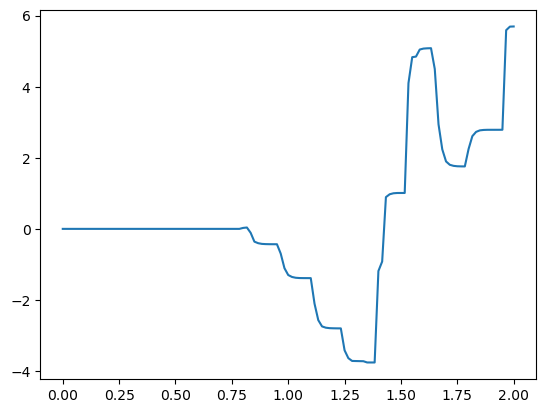

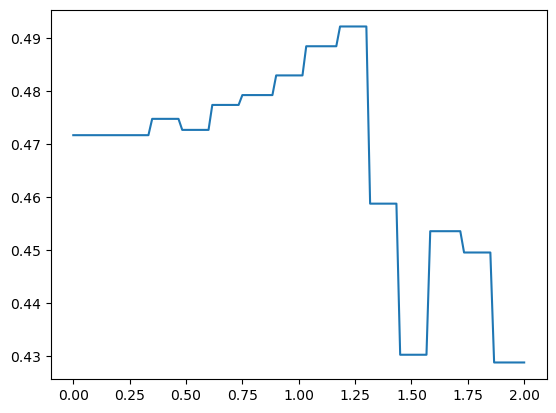

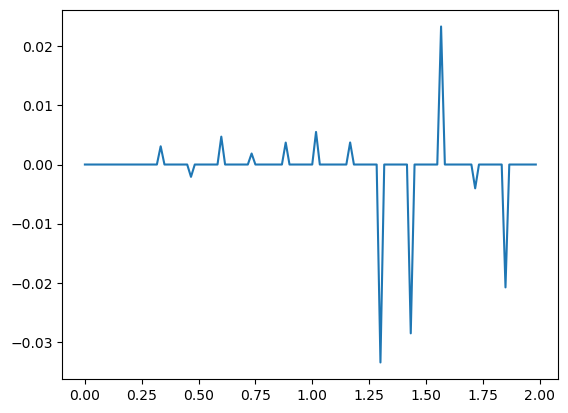

In [62]:
action_proactive = np.load("/home/kiyanoush/Cpp_ws/src/haptic_finger_control/RT-Data/proactive/011/robot_velocity.npy")
stem_proactive = np.load("/home/kiyanoush/Cpp_ws/src/haptic_finger_control/RT-Data/proactive/011/localisation.npy")
stem_proactive = drop_missed_frames(stem_proactive)
plt.plot(np.arange(len(action_proactive))/60, action_proactive[:, -1]*57)
plt.figure()
plt.plot(np.arange(len(stem_proactive))/60, stem_proactive)
print(stem_proactive.shape)
plt.figure()
plt.plot(np.arange(len(stem_proactive)-1)/60, np.diff(stem_proactive[:, 0]))

(122, 1)


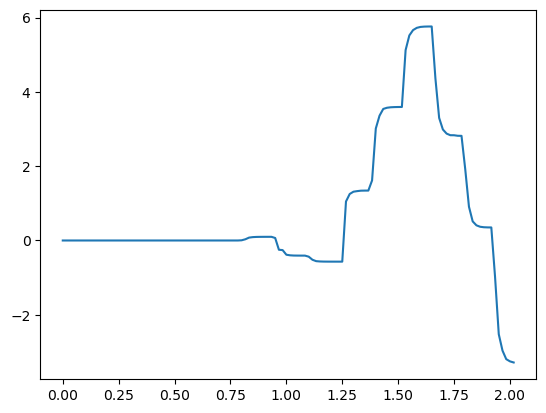

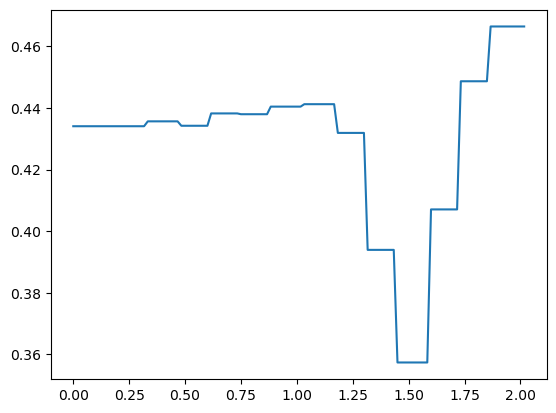

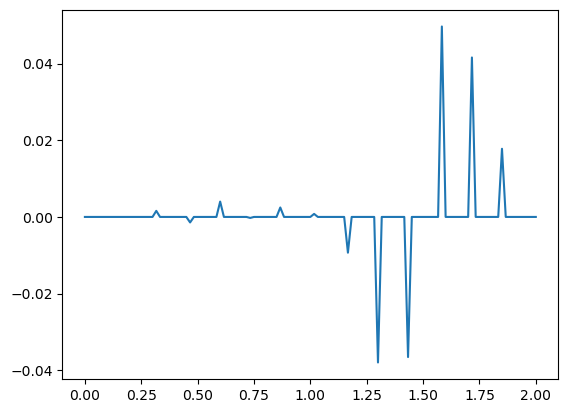

In [65]:
action_proactive = np.load("/home/kiyanoush/Cpp_ws/src/haptic_finger_control/RT-Data/proactive/011/robot_velocity.npy")
stem_proactive = np.load("/home/kiyanoush/Cpp_ws/src/haptic_finger_control/RT-Data/proactive/011/localisation.npy")
stem_proactive = drop_missed_frames(stem_proactive)
plt.plot(np.arange(len(action_proactive))/60, action_proactive[:, -1]*57)
plt.figure()
plt.plot(np.arange(len(stem_proactive))/60, stem_proactive)
print(stem_proactive.shape)
plt.figure()
plt.plot(np.arange(len(stem_proactive)-1)/60, np.diff(stem_proactive[:, 0]))

(121, 1)


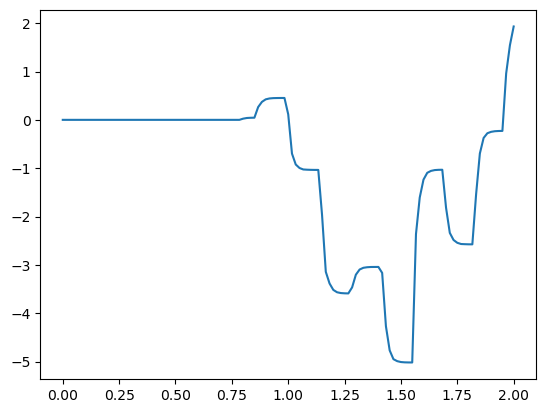

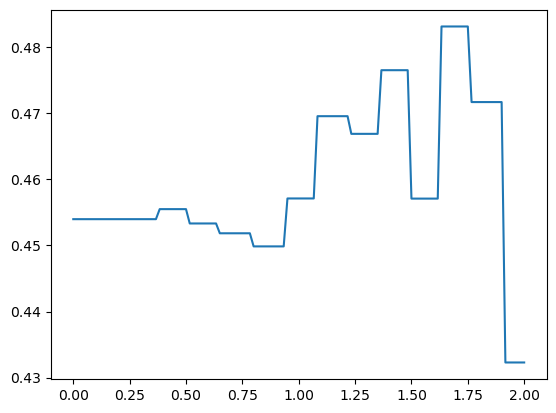

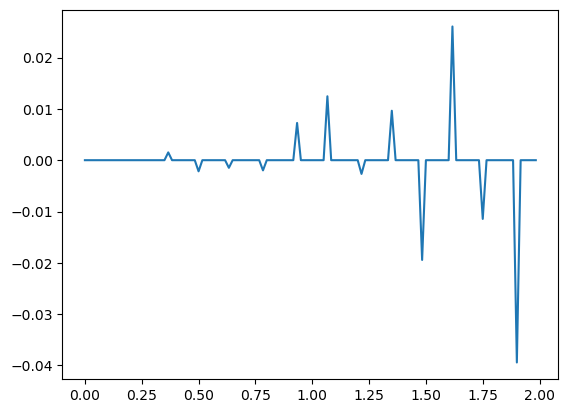

In [68]:
action_proactive = np.load("/home/kiyanoush/Cpp_ws/src/haptic_finger_control/RT-Data/proactive/final_tests/001/robot_velocity.npy")
stem_proactive = np.load("/home/kiyanoush/Cpp_ws/src/haptic_finger_control/RT-Data/proactive/final_tests/001/localisation.npy")
stem_proactive = drop_missed_frames(stem_proactive)
plt.plot(np.arange(len(action_proactive))/60, action_proactive[:, -1]*57)
plt.figure()
plt.plot(np.arange(len(stem_proactive))/60, stem_proactive)
print(stem_proactive.shape)
plt.figure()
plt.plot(np.arange(len(stem_proactive)-1)/60, np.diff(stem_proactive[:, 0]))

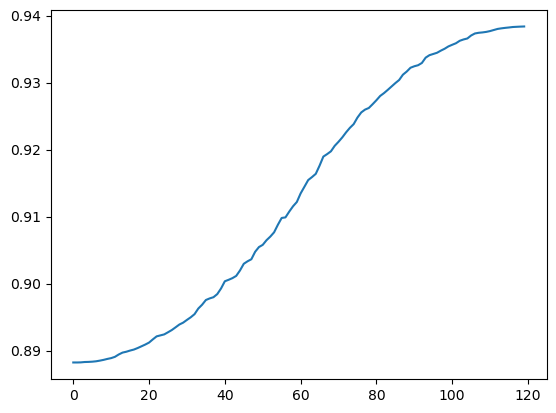

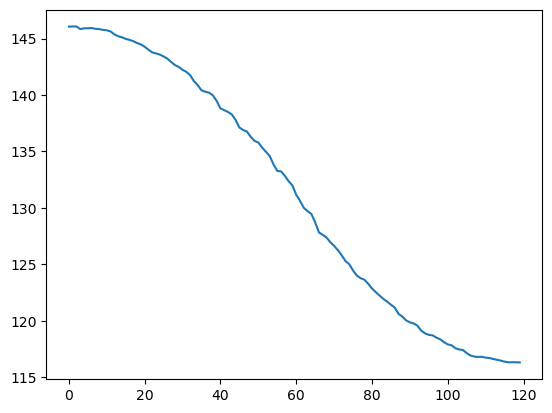

In [72]:
action_circular = np.load("/home/kiyanoush/Cpp_ws/src/haptic_finger_control/RT-Data/proactive/final_tests/016/robot_pose.npy")
plt.plot(action_circular[:, 2])
plt.figure()
plt.plot(action_circular[:, 5])